In [5]:
import matplotlib.pyplot as plt
import cv2
from scipy.io import loadmat
import numpy as np
import numpy as np
import cv2
from numpy.linalg import inv
from scipy.io import loadmat
from collections import defaultdict
from matplotlib import pyplot as plt
import pickle


n_joints = 13
joint_pairs = [(0,1),(1,2),(2,3),(3,4),(2,5),(5,6),(2,7),(7,8),(8,9),(7,10),(10,11),(7,12)]
data_folder = '/data/LiftFly3D/openmonkey/OMS_Dataset/'

data = loadmat(data_folder + 'Data.mat')
name = data['T'][0][0]['name']
label = data['T'][0][0]['data']


def get_pts2d(i, n, label):
    #i = np.squeeze((name == n).nonzero()[0])
    jt_loc = np.zeros((13,2))
    for j in range(13):
        jt_loc[j] = [label[i][5+2*j],label[i][4+2*j]]
        
    return jt_loc

def get_img_overlay(i, name, label):
    label = label[i]
    name = name[i][0][0]
    img_name = data_folder + 'Images/{}'.format(name)
    image = cv2.imread(img_name)
    jt_loc = {}
    h = label[2]
    w = label[3]
    for j in range(13):
        jt_loc[j] = (label[5+2*j],label[4+2*j])

    for j, (jt1, jt2) in enumerate(joint_pairs):
        pt1 = jt_loc[jt1]
        pt2 = jt_loc[jt2]
        if pt1[0] < 1 or pt1[1] < 1 or pt2[0] < 1 or pt2[1] < 1 or pt1[0] > w or pt1[1] > h or pt2[0] > w or pt2[1] > h:
            continue
        else:
            cv2.line(image, pt1, pt2, [0, 0, 0], 3)
    return image, name


# batch(batch#)_(frame#)_(cameraID).jpg , Eg. batch7_000003120_18064162.jpg
def parse_img_name(name):
    sp = name.split('_')
    batch_id = sp[0].replace('batch', '')
    frame_id = int(sp[1])
    cam_id = int(sp[2].replace('.jpg', ''))
    #print(name, batch_id, frame_id, cam_id)
    return batch_id, frame_id, cam_id

In [6]:
batch_w_3d = ['7', '9', '9a', '9b', '10', '11']

cam_list = np.unique([int(n[0][0].split('_')[-1].replace('.jpg','')) for n in name]).tolist()
print(cam_list)

pose_result = dict()
for btch in batch_w_3d:
    annotations = loadmat(data_folder + 'Batch{}/coords_3D.mat'.format(btch))
    print('annotations', annotations['coords'].shape)
    
    l = list()
    for n in name:
        n = n[0][0]
        batch_id, frame_id, cam_id = parse_img_name(n)
        if batch_id == btch:
            l.append(frame_id)
    max_num_images = max(l) + 1
    print(max_num_images)
    
    points2d = np.zeros(((len(cam_list)), max_num_images, n_joints, 2))
    points3d = np.zeros((max_num_images, n_joints, 3))

    for i, n in enumerate(name):
        n = n[0][0]
        batch_id, frame_id, cam_id = parse_img_name(n)
        if batch_id == btch:
            #print(cam_id, frame_id)
            points2d[cam_list.index(cam_id), frame_id] = get_pts2d(i, n, label)
            
            ii = frame_id * 13
            for jt in range(13):
                try:
                    points3d[frame_id, jt] = annotations['coords'][ii+jt, 1:4]
                except:
                    continue

    pickle.dump({"points3d":points3d, "points2d":points2d}, open(f'pose_result_{btch}.pkl', 'wb'))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 18064162, 18260132, 18260133, 18260136, 18260361, 18260369, 18260370, 18260972, 18260973, 18260975, 18260976, 18260977, 18260978, 18260979, 18260981, 18260982, 18260983, 18260984, 18260985, 18260986, 18260989, 18260990, 18260991, 18260992, 18260993, 18260994, 18260995, 18260998, 18260999, 18261000, 18261002, 18261003, 18261004, 18261005, 18261006, 18261007, 18261008, 18261009, 18261010, 18261011, 18261012, 18261013, 18261014, 18261017, 18261018, 18261019, 18261020, 18261021, 18261022, 18261023, 18261024, 18261025, 18261026, 18261027, 18261028, 18261029, 18261030, 18261031, 18261032, 18261033, 18261034, 18261035, 18261112]
annotations (7384, 4)
26741
annotations (9230, 4)
27101
annotations (4511, 4)
26981
annotations (12584, 4)
27961
annotations (18161, 4)
88061
annotations (43017, 4)
135241


(13, 2)


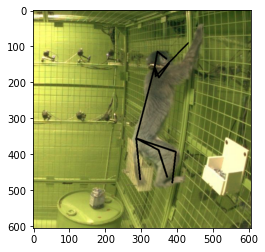

In [28]:
btch, frame, cmr =11, 40, 18261018
#d = pickle.load(open(f'pose_result_{btch}.pkl', 'rb'))

img_name = data_folder + 'Images/batch' + str(btch) + '_' + str(frame).zfill(9) + '_' + str(cmr) + '.jpg'
image = cv2.imread(img_name)

pts2d = d["points2d"][cam_list.index(cmr), frame].astype(int)
print(pts2d.shape)

for j, (jt1, jt2) in enumerate(joint_pairs):
    cv2.line(image, (pts2d[jt1][0], pts2d[jt1][1]), (pts2d[jt2][0], pts2d[jt2][1]), [0, 0, 0], 3)
plt.imshow(image)

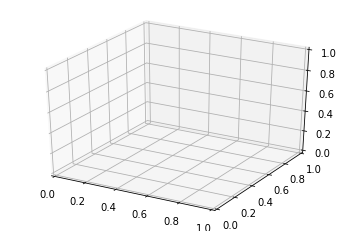

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
writer = FFMpegWriter(fps=1)

with writer.saving(fig, "test.mp4", 100):
    for frm in np.unique(d["points3d"].nonzero()[0]):
        pts3d = d["points3d"][frm]
        for j, (jt1, jt2) in enumerate(joint_pairs):
            ax.plot(pts3d[[jt1, jt2], 0], pts3d[[jt1, jt2], 1], pts3d[[jt1, jt2], 2])
        writer.grab_frame()
        ax.cla()

In [33]:
from IPython.display import Video
Video('test.mp4', embed=True)

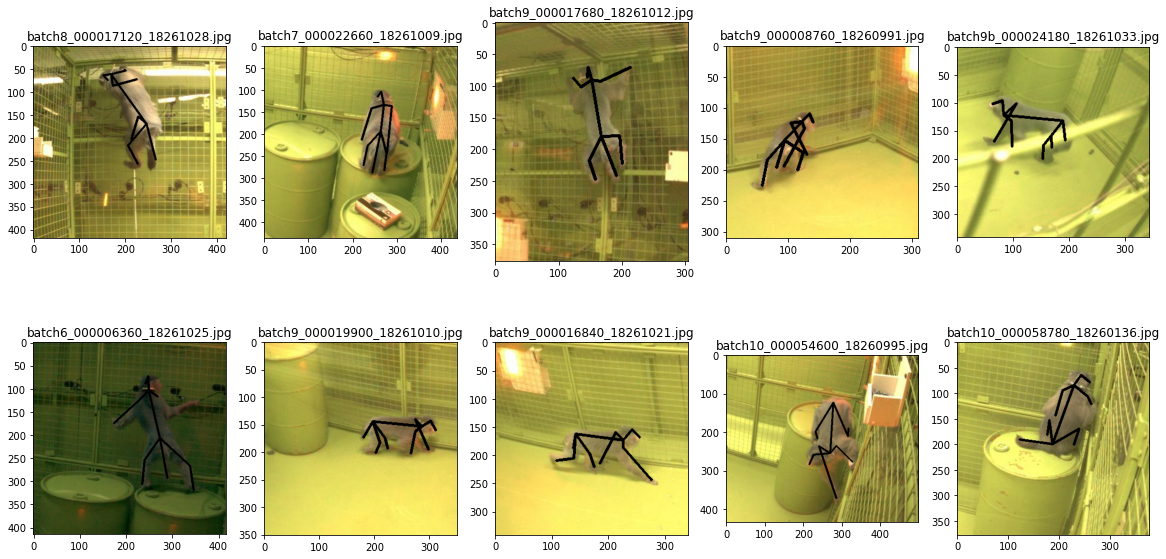

In [221]:
fig, axs = plt.subplots(2, 5, figsize=(20,10))
axs = axs.flatten()

for ax in axs:
    img, title = get_img_overlay(np.random.randint(label.shape[0]), name, label)
    ax.imshow(img)
    ax.set_title(title)

In [134]:
with open(data_folder + 'Batch{}/intrinsic.txt'.format(btch)) as f:
    lines = f.readlines()
    cameras = {}
    for i in range(0, len(lines), 5):
        cam_line = lines[i]
        K_lines = lines[i + 1:i + 4]
        ds = lines[i + 4].rstrip('\n')
        d = ds.split(' ')
        d1 = float(d[0])
        d2 = float(d[1])
        cam = cam_line.strip().split(' ')[1]
        K = np.reshape(np.array([float(f) for K_line in K_lines for f in K_line.strip().split(' ')]), [3, 3])
        cameras[cam] = {'K': K, 'd1': d1, 'd2': d2}
        
# Extrinsics
with open(data_folder + 'Batch{}/camera.txt'.format(btch)) as f:
    lines = f.readlines()
    for i in range(3, len(lines), 5):
        cam_line = lines[i]
        C_line = lines[i + 1]
        R_lines = lines[i + 2:i + 5]
        cam = cam_line.strip().split(' ')[1]
        C = np.array([float(f) for f in C_line.strip().split(' ')])
        R = np.reshape(np.array([float(f) for R_line in R_lines for f in R_line.strip().split(' ')]), [3, 3])
        P = cameras[cam]['K'] @ (R @ (np.concatenate((np.identity(3), -np.reshape(C, [3, 1])), axis=1)))
        cameras[cam]['R'] = R
        cameras[cam]['C'] = C
        cameras[cam]['P'] = P

cameras_copy = dict()
for k, v in cameras.items():
    cameras_copy[k] = dict()
    cameras_copy[cam_list.index(int(k))] = [v["R"], -1 * np.dot(v["R"], v["C"]), (v["d1"], v["d2"]), np.arange(13)]

import pickle
pickle.dump(cameras_copy, open('./cameras.pkl', 'wb'))

def distort_point(u_x, u_y, cam):
    K = cameras[cam]['K']
    d1 = cameras[cam]['d1']
    d2 = cameras[cam]['d2']

    invK = inv(K)
    z = np.array([u_x, u_y, 1])
    nx = invK.dot(z)

    x_dn = nx[0] * (1 + d1 * (nx[0] * nx[0] + nx[1] * nx[1]) + d2 * (nx[0] * nx[0] + nx[1] * nx[1]) * (
             nx[0] * nx[0] + nx[1] * nx[1]))
    y_dn = nx[1] * (1 + d1 * (nx[0] * nx[0] + nx[1] * nx[1]) + d2 * (nx[0] * nx[0] + nx[1] * nx[1]) * (
             nx[0] * nx[0] + nx[1] * nx[1]))

    z2 = np.array([x_dn, y_dn, 1])
    x_d = K.dot(z2)

    return np.array([x_d[0], x_d[1]])

def get_projection(cam, coords_3d):
    P = cameras[cam]['P']
    u = P @ np.append(coords_3d, [1])
    u = u[0:2] / u[2]
    proj = distort_point(u[0], u[1], cam)
    return proj

def display_plot(I):
    fig = plt.figure()
    
    for i in range(8):
        sub1 = plt.subplot(2, 4, i+1)
        sub1.set_xticks(())
        sub1.set_yticks(())
        sub1.imshow(I[i])

    fig.tight_layout()
    #plt.show()
    # fig.savefig(strng)

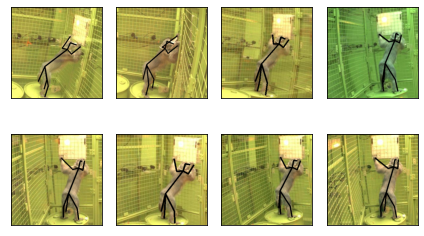

In [74]:
Data = defaultdict(dict)
btch = 7
frm = 1
annotations = loadmat(data_folder + 'Batch{}/coords_3D.mat'.format(btch))
parameters = loadmat(data_folder + 'Batch{}/crop_para.mat'.format(btch))
pt = parameters['crop'].transpose()[0]
u = np.unique(pt, axis=0)
q = np.where(pt == u[frm])
params = {}
I = {}
frame = 7

for i in range(8):
    params[i] = (parameters['crop'][q[0][2*i]][2],parameters['crop'][q[0][2*i]][3])
    frame = parameters['crop'][q[0][2*i]][0]
    cmr = parameters['crop'][q[0][2*i]][1]
    img_name = data_folder + 'Images/batch' + str(btch) + '_' + str(frame).zfill(9) + '_' + str(cmr) + '.jpg'
    image = cv2.imread(img_name)
    Data[str(cmr)] = {}
    h = parameters['crop'][q[0][2*i]][5]
    w = parameters['crop'][q[0][2*i]][4]

    ii = frm*13
    for jt in range(13):
        coords = annotations['coords'][ii+jt, 1:4]
        if coords is not None:
            x, y = get_projection(str(cmr), coords)
            proj = distort_point(x, y, str(cmr))
            Data[str(cmr)][jt] = {'reprojected': (int(y), int(x))}
        else:
            Data[str(cmr)][jt] = {'reprojected': None}

    for j, (jt1, jt2) in enumerate(joint_pairs):
        coords1 = Data[str(cmr)][jt1]['reprojected']
        x, y = coords1
        x = x - params[i][1]
        y = y - params[i][0]
        pt1 = (y, x)

        coords1 = Data[str(cmr)][jt2]['reprojected']
        x, y = coords1
        x = x - params[i][1]
        y = y - params[i][0]
        pt2 = (y, x)
        if pt1[0] < 1 or pt1[1] < 1 or pt2[0] < 1 or pt2[1] < 1 or pt1[0] > w or pt1[1] > h or pt2[0] > w or pt2[1] > h:
            continue
        else:
            cv2.line(image, pt1, pt2, [0, 0, 0], 3)
        
    I[i] = image
    a = 'Rep/batch' + str(btch) + '_' + str(frame).zfill(9) + '_' + str(cmr) + '.jpg'
display_plot(I)

In [210]:
loadmat(data_folder + 'Batch{}/coords_3D.mat'.format(btch))['coords'].shape[0] / (13 * 4)

827.25